In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Define constants
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_CLASSES = 10  # Number of classes to identify
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DENSE_LAYERS = [256, 512, 1024, 1024]

In [3]:
# Define directories
train_dirs = ['./dataset/train/train1', './dataset/train/train2', './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create multiple train generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Custom generator to merge multiple directories


def combined_generator(generators):
    while True:
        for generator in generators:
            yield next(generator)


train_generator = combined_generator(train_generators)

# Validation and test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

class Precision(Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.predicted_positives.assign_add(K.sum(y_pred))

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

class Recall(Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.actual_positives = self.add_weight(name='ap', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.actual_positives.assign_add(K.sum(y_true))

    def result(self):
        return self.true_positives / (self.actual_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.actual_positives.assign(0)

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


# Novas layers
Conv2D

In [6]:
model = Sequential([
    Conv2D(DENSE_LAYERS[0], (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(DENSE_LAYERS[1], (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(DENSE_LAYERS[2], (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(DENSE_LAYERS[3]),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1

In [7]:
# Definir os Callbacks

# Para salvar o melhor modelo com base na acurácia de validação
checkpoint = ModelCheckpoint("models/02_com_data_augmentation_batch_size_64_layers_[256,512,1024,1024].keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Parar o treinamento se não houver melhoria na loss após x epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Salvar para csv
csv_logger = CSVLogger(f'logs/02_com_data_augmentation_batch_size_{BATCH_SIZE}_image_size_{IMG_SIZE}_layers_{DENSE_LAYERS}.csv', append=True)

# Reduzir a learning rate se não houver melhoria na loss após x epochs (lembrar de deixar este valor sempre menor que a patience no early_stopping!!)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [8]:
# Calculate steps per epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr]
)

# Evaluate the model
# Evaluate the model
results = model.evaluate(test_generator)
loss, accuracy, precision, recall, f1_score = results[:5]
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")


623/624 [============================>.] - ETA: 0s - loss: 2.0982 - accuracy: 0.2777 - precision: 0.3752 - recall: 0.0840 - f1_score: 0.1372

c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Precision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Recall implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_accuracy improved from -inf to 0.41617, saving model to models\02_com_data_augmentation.keras
157/157 [==============================] - 3s 20ms/step - loss: 1.5938 - accuracy: 0.4300 - precision: 0.6834 - recall: 0.1239 - f1_score: 0.2098
Test Loss: 1.5938135385513306
Test Accuracy: 0.4300000071525574
Test Precision: 0.6833977103233337
Test Recall: 0.12389999628067017
Test F1 Score: 0.2097688615322113


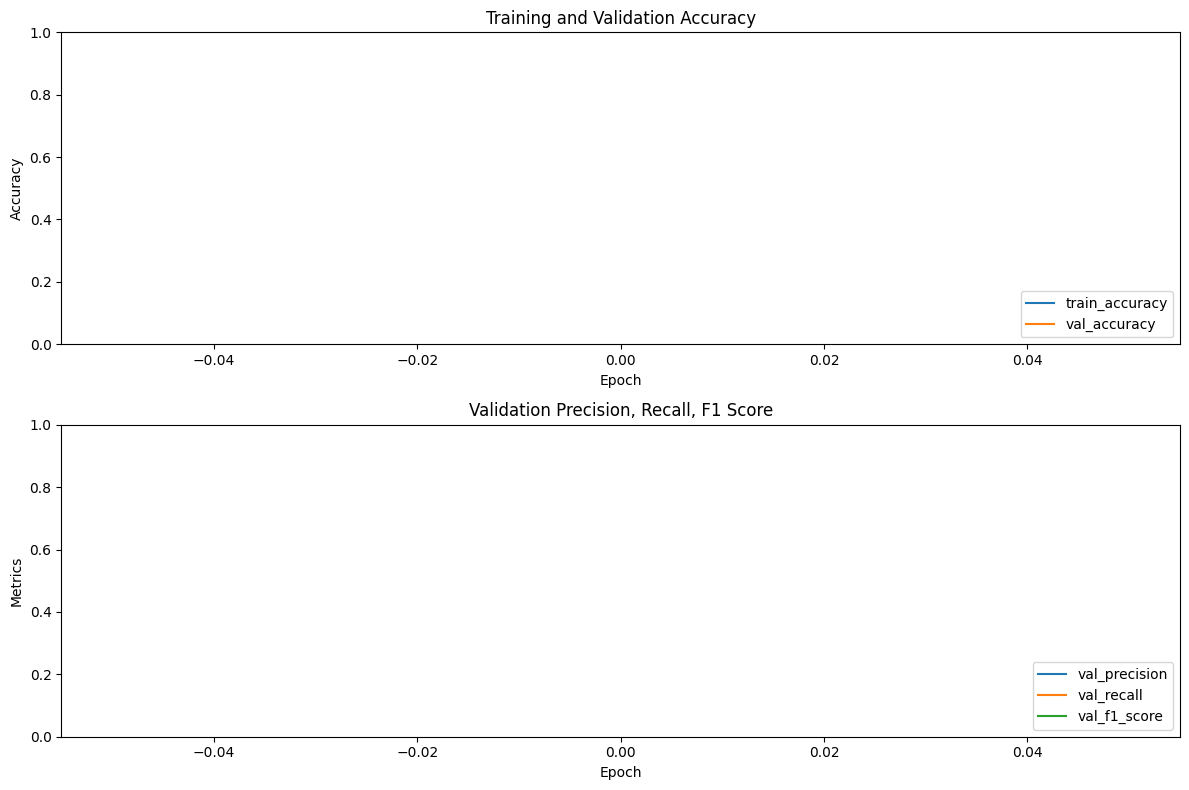

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Validation Precision, Recall, F1 Score')

plt.savefig(f'./plots/02_com_data_augmentation_batch_{BATCH_SIZE}_layers_{DENSE_LAYERS}.png')
plt.tight_layout()
plt.show()